In [56]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [57]:
def scrape_eci_data(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: Status code {response.status_code}")

    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', class_='table')

    if not table:
        raise Exception("Could not find the results table on the page")

    data = []
    for row in table.find_all('tr')[1:]:
        cols = row.find_all('td')
        if len(cols) == 4:
            party = cols[0].text.strip()
            won = int(cols[1].text.strip())
            leading = int(cols[2].text.strip())
            total = int(cols[3].text.strip())
            party_link = cols[1].find('a')['href']
            data.append({
                'Party': party,
                'Won': won,
                'Leading': leading,
                'Total': total,
                'Link': party_link
            })

    return pd.DataFrame(data)


In [58]:
def scrape_candidate_data(url, party_name):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    try:
        response = requests.get(url, headers=headers)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Failed to fetch data from {url}: {str(e)}")
        return pd.DataFrame()

    soup = BeautifulSoup(response.content, 'html.parser')
    table = soup.find('table', class_='table-striped')

    if not table:
        print(f"Could not find the candidate data table on the page: {url}")
        return pd.DataFrame()

    data = []
    rows = table.find_all('tr')

    for row in rows[1:]:
        cols = row.find_all('td')
        if len(cols) >= 5:
            total_votes = cols[3].text.strip().replace(',', '')
            margin = cols[4].text.strip().replace(',', '')

            data.append({
                'Serial Number': cols[0].text.strip(),
                'Constituency': cols[1].text.strip(),
                'Winning Candidate': cols[2].text.strip(),
                'Total Votes': int(total_votes) if total_votes != '-' else 0,
                'Margin': int(margin) if margin != '-' else 0,
                'Party': party_name
            })

    if not data:
        print(f"No data found in the table for URL: {url}")

    return pd.DataFrame(data)


In [101]:
url = "https://results.eci.gov.in/PcResultGenJune2024/index.htm"
df = scrape_eci_data(url)
df.head()




,Party,Won,Leading,Total,Link
0,Bharatiya Janata Party - BJP,240,0,240,partywisewinresultState-369.htm
1,Indian National Congress - INC,99,0,99,partywisewinresultState-742.htm
2,Samajwadi Party - SP,37,0,37,partywisewinresultState-1680.htm
3,All India Trinamool Congress - AITC,29,0,29,partywisewinresultState-140.htm
4,Dravida Munnetra Kazhagam - DMK,22,0,22,partywisewinresultState-582.htm


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Party    42 non-null     object
 1   Won      42 non-null     int64 
 2   Leading  42 non-null     int64 
 3   Total    42 non-null     int64 
 4   Link     42 non-null     object
dtypes: int64(3), object(2)
memory usage: 1.8+ KB


In [103]:
parties_df = pd.DataFrame(df)
parties_df.to_csv('parties_data.csv', index=False)
print("Parties data saved successfully.")

Parties data saved successfully.


In [104]:

def independent_candidates_won(df):
    # Filter independent candidates
    independents = df[df['Party'].str.contains('Independent', case=False, na=False)]
    total_independents = independents['Total'].sum()

    # Create a DataFrame
    data = {'Category': ['Independent Candidates'], 'Count': [total_independents]}
    independent_candidates_df = pd.DataFrame(data)

    # Plot the data
    plt.figure(figsize=(8, 6))
    bars = plt.bar(independent_candidates_df['Category'], independent_candidates_df['Count'])
    plt.title('Number of Independent Candidates Who Won')

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), va='bottom', ha='center')

    plt.show()

    return independent_candidates_df

# Assuming 'df' is already defined and contains the relevant data
independent_candidates_df = independent_candidates_won(df)

# Save to CSV
csv_filename = 'independent_candidates_won.csv'
independent_candidates_df.to_csv(csv_filename, index=False)

csv_filename


'independent_candidates_won.csv'

In [105]:
def overall_election_statistics(df):
    total_seats = df['Total'].sum()
    total_parties = len(df)
    avg_seats = df['Total'].mean()

    stats = ['Total Seats', 'Total Parties', 'Avg Seats per Party']
    values = [total_seats, total_parties, avg_seats]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(stats, values, color='skyblue', edgecolor='black')

    for bar, value in zip(bars, values):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(),
                 f'{value:.2f}' if isinstance(value, float) else f'{value}',
                 ha='center', va='bottom', fontsize=12)

    plt.title('Overall Election Statistics', fontsize=16)
    plt.ylabel('Count', fontsize=14)
    plt.tight_layout()
    plt.show()

    return (f"Overall Election Statistics:\n"
            f"Total Seats: {total_seats}\n"
            f"Total Parties: {total_parties}\n"
            f"Average Seats per Party: {avg_seats:.2f}")

print(overall_election_statistics(df))


Overall Election Statistics:
Total Seats: 543
Total Parties: 42
Average Seats per Party: 12.93


In [124]:

election_statistics = {
    'Statistic': ['Total Seats', 'Total Parties', 'Average Seats per Party'],
    'Value': [543, 42, 12.93]
}

# Create a DataFrame
df_statistics = pd.DataFrame(election_statistics)

# Specify the CSV filename
csv_filename = 'election_statistics.csv'

# Save the DataFrame to CSV
df_statistics.to_csv(csv_filename, index=False)

print(f"Election statistics saved to {csv_filename}")


Election statistics saved to election_statistics.csv


In [106]:
def party_size_distribution(df):
    df_filtered = df[df['Party'] != 'Independent - IND']

    size_bins = [0, 2, 6, 11, 51, 101, float('inf')]
    labels = ['1', '2-5', '6-10', '11-50', '51-100', '100+']
    df_filtered['Size Category'] = pd.cut(df_filtered['Total'], bins=size_bins, labels=labels, right=False)

    distribution = df_filtered['Size Category'].value_counts().sort_index()

    plt.figure(figsize=(10, 6))
    ax = distribution.plot(kind='bar', color='skyblue', edgecolor='black')

    for p in ax.patches:
        ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

    plt.title('Party Size Distribution', fontsize=16)
    plt.xlabel('Number of Seats', fontsize=14)
    plt.ylabel('Number of Parties', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

    return f"Party size distribution:\n{distribution.to_string()}"

print(party_size_distribution(df))


Party size distribution:
Size Category
1         17
2-5       14
6-10       3
11-50      5
51-100     1
100+       1


In [107]:
import pandas as pd
import io

# Assuming your data is represented as a string
data = """
Size Category
1         17
2-5       14
6-10       3
11-50      5
51-100     1
100+       1
"""

# Convert the string data into a DataFrame
party_size_distribution_df = pd.read_csv(io.StringIO(data), delim_whitespace=True)

# Save to CSV
csv_filename = 'party_size_distribution.csv'
party_size_distribution_df.to_csv(csv_filename, index=False)

csv_filename  # Returns the filename for confirmation


'party_size_distribution.csv'

No single party has a majority. Coalition government likely. (Majority required: 272)


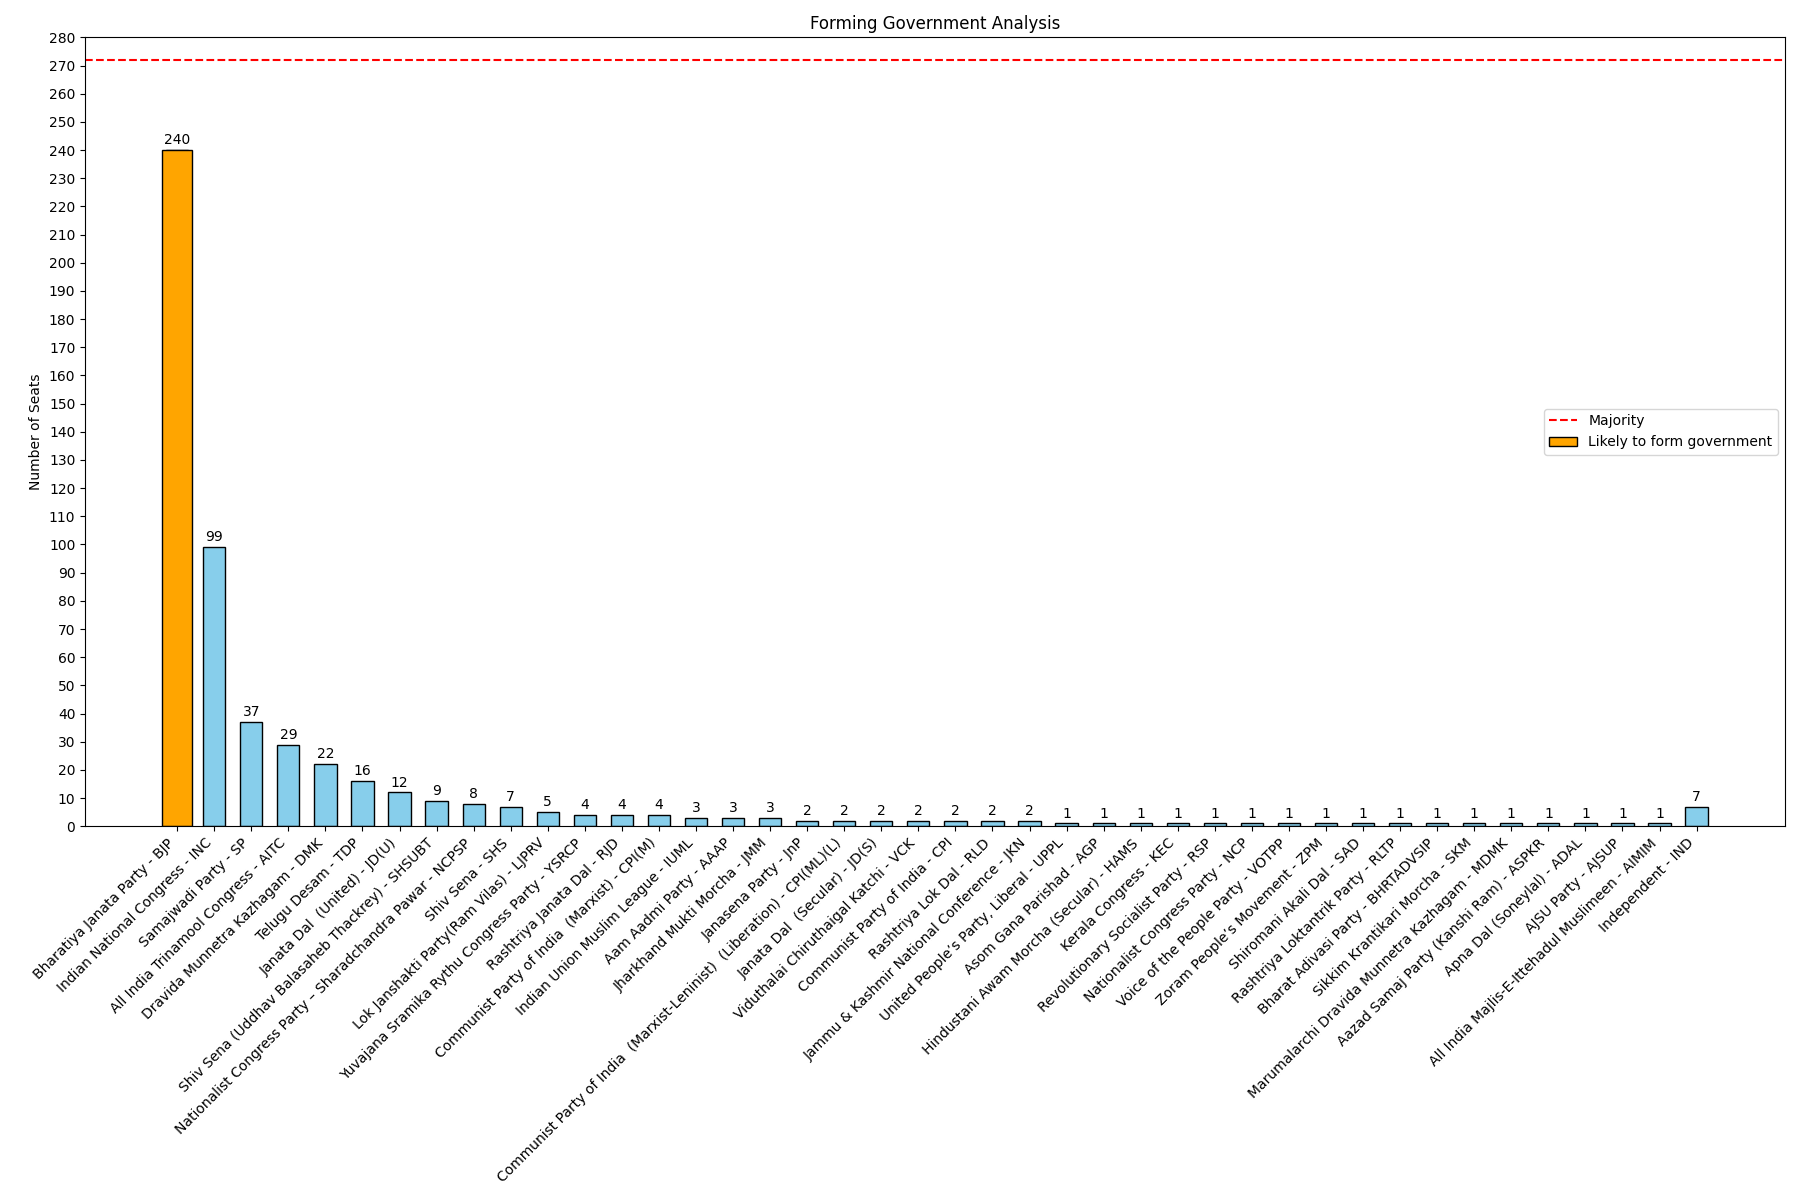

In [120]:
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

def forming_government(df):
    total_seats = df['Total'].sum()
    majority = total_seats // 2 + 1
    top_party = df.loc[df['Total'].idxmax()]

    plt.figure(figsize=(18, 12))
    bars = plt.bar(df['Party'], df['Total'], color='skyblue', width=0.6, edgecolor='black')

    plt.bar(top_party['Party'], top_party['Total'], color='orange', label='Likely to form government', edgecolor='black')
    plt.axhline(y=majority, color='red', linestyle='--', label='Majority')

    for bar in bars:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{int(bar.get_height())}", ha='center', va='bottom')

    plt.ylim(0, max(df['Total']) + 10)
    plt.yticks(range(0, max(df['Total']) + 50, 10))
    plt.title('Forming Government Analysis')
    plt.ylabel('Number of Seats')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    plt.tight_layout()

    # Save plot to a file
    plot_filename = 'forming_government.png'
    plt.savefig(plot_filename)
    plt.close()

    # Display plot interactively (in Jupyter)
    plt.show()

    if top_party['Total'] >= majority:
        return f"{top_party['Party']} is likely to form the government with {top_party['Total']} seats (Majority: {majority})"
    else:
        return f"No single party has a majority. Coalition government likely. (Majority required: {majority})"


result = forming_government(df)
print(result)

# Display the saved image
Image(filename='forming_government.png')


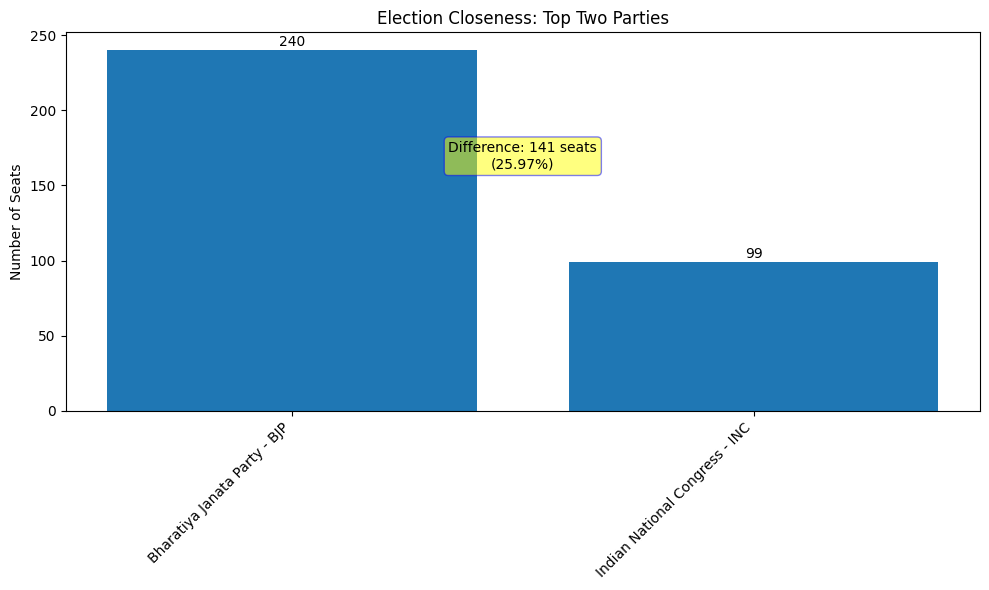

The election was decided by a margin of 141 seats (25.97% of total seats)


In [65]:
def election_closeness(df):
    top_two = df.nlargest(2, 'Total')
    difference = top_two.iloc[0]['Total'] - top_two.iloc[1]['Total']
    total_seats = df['Total'].sum()
    closeness_percentage = (difference / total_seats) * 100

    plt.figure(figsize=(10, 6))
    bars = plt.bar(top_two['Party'], top_two['Total'])

    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1, f"{int(bar.get_height())}", ha='center', va='bottom')

    text_box_y = (max(top_two.iloc[0]['Total'], top_two.iloc[1]['Total']) + min(top_two.iloc[0]['Total'], top_two.iloc[1]['Total'])) / 2
    plt.text(0.5, text_box_y, f"Difference: {difference} seats\n({closeness_percentage:.2f}%)", ha='center', va='center', bbox=dict(boxstyle="round,pad=0.3", fc="yellow", ec="b", lw=1, alpha=0.5))

    plt.title('Election Closeness: Top Two Parties')
    plt.ylabel('Number of Seats')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return f"The election was decided by a margin of {difference} seats ({closeness_percentage:.2f}% of total seats)"

print(election_closeness(df))



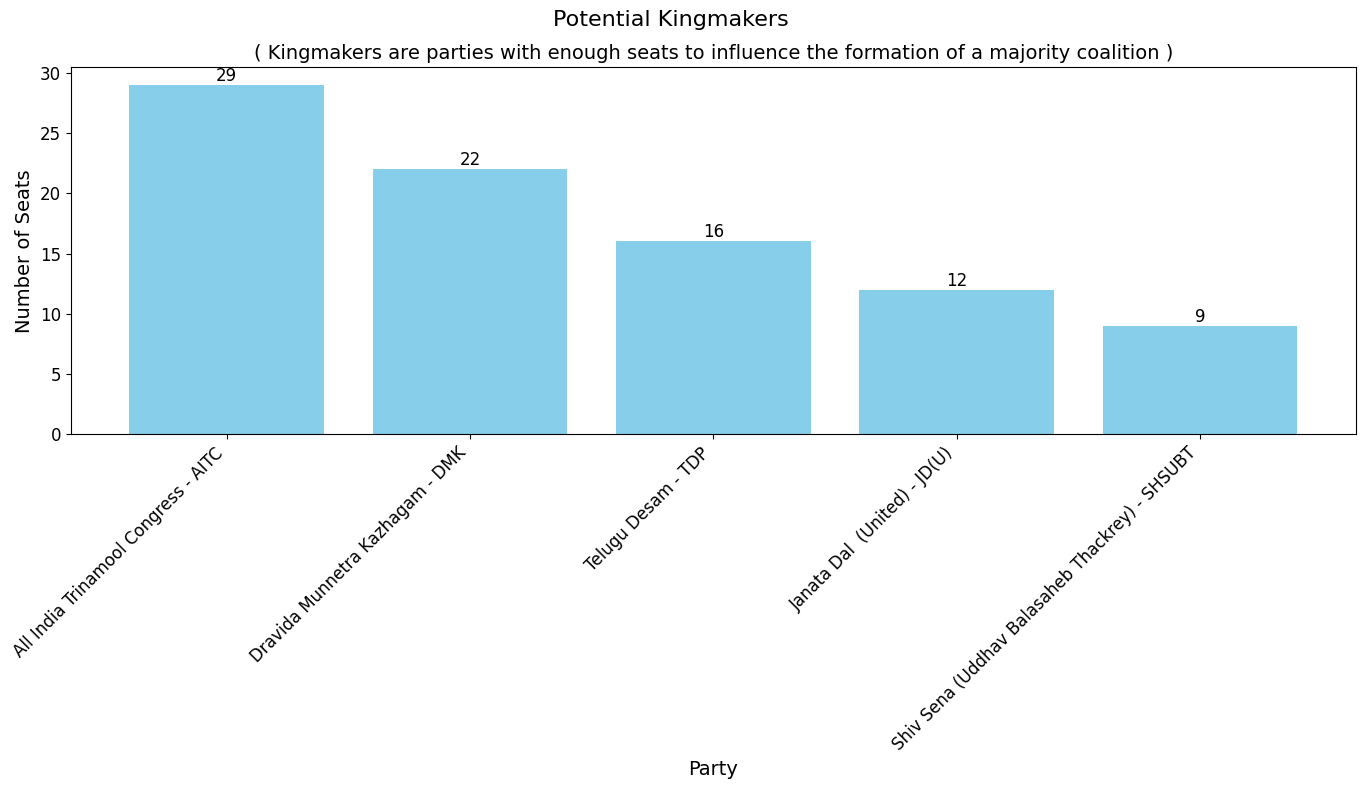

Potential kingmakers:
                                         Party  Total
           All India Trinamool Congress - AITC     29
               Dravida Munnetra Kazhagam - DMK     22
                            Telugu Desam - TDP     16
                  Janata Dal  (United) - JD(U)     12
Shiv Sena (Uddhav Balasaheb Thackrey) - SHSUBT      9


In [66]:
def potential_kingmakers(df):
    total_seats = df['Total'].sum()
    majority = total_seats // 2 + 1
    top_party_seats = df['Total'].max()
    kingmakers = df[(df['Total'] > 0) & (df['Total'] < (majority - top_party_seats))]
    kingmakers = kingmakers.sort_values('Total', ascending=False).head()

    plt.figure(figsize=(14, 8))
    bars = plt.bar(kingmakers['Party'], kingmakers['Total'], color='skyblue')

    plt.suptitle('Potential Kingmakers', fontsize=16)
    plt.title('( Kingmakers are parties with enough seats to influence the formation of a majority coalition )', fontsize=14)
    plt.ylabel('Number of Seats', fontsize=14)
    plt.xlabel('Party', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height}', ha='center', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()

    return f"Potential kingmakers:\n{kingmakers[['Party', 'Total']].to_string(index=False)}"

print(potential_kingmakers(df))


In [134]:
import csv

# Example data in text format
text_data = """
                                         Party  Total
           All India Trinamool Congress - AITC     29
               Dravida Munnetra Kazhagam - DMK     22
                            Telugu Desam - TDP     16
                  Janata Dal  (United) - JD(U)     12
Shiv Sena (Uddhav Balasaheb Thackrey) - SHSUBT      9
"""

# Parse the text data into a list of lists (rows)
rows = []
for line in text_data.strip().split('\n'):
    if line.strip():  # Ignore empty lines
        parts = line.strip().split('  ')  # Adjust the split based on the actual spacing
        rows.append([parts[0].strip(), parts[1].strip()])

# Specify the file path where you want to save the CSV
csv_file = "potential_kingmakers.csv"

# Write data to CSV file
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Party', 'Total'])  # Write header
    writer.writerows(rows)  # Write rows of data

print(f"CSV file '{csv_file}' has been created successfully.")


CSV file 'potential_kingmakers.csv' has been created successfully.


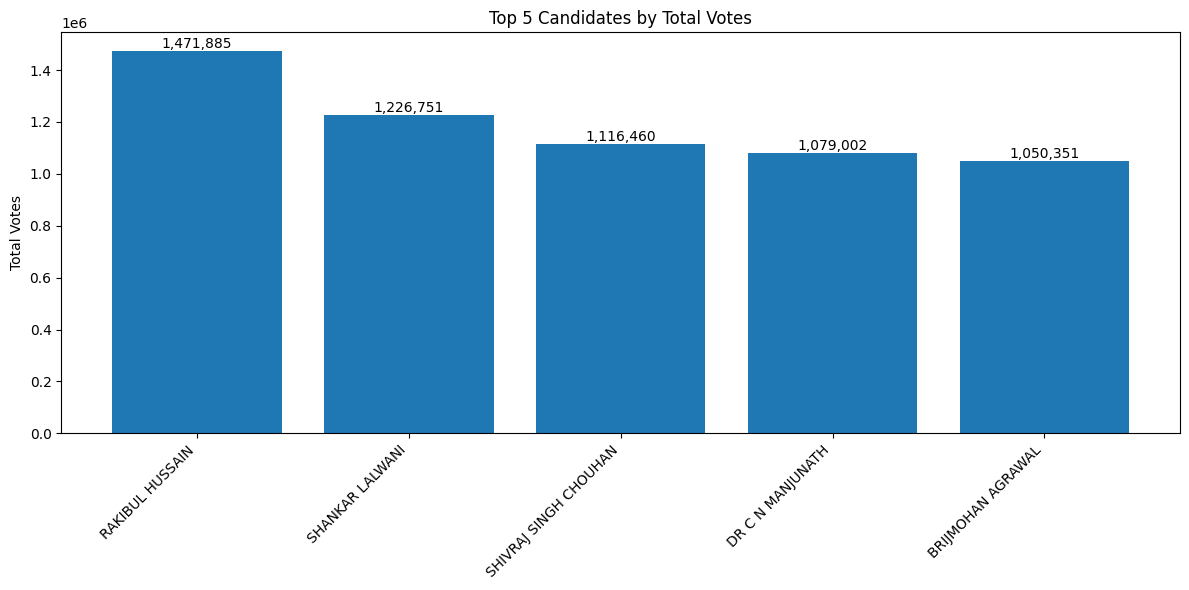

Top 5 candidates by total votes:
    Winning Candidate                          Party        Constituency  Total Votes
      RAKIBUL HUSSAIN Indian National Congress - INC          Dhubri (2)      1471885
      SHANKAR LALWANI   Bharatiya Janata Party - BJP          INDORE(26)      1226751
SHIVRAJ SINGH CHOUHAN   Bharatiya Janata Party - BJP         VIDISHA(18)      1116460
     DR C N MANJUNATH   Bharatiya Janata Party - BJP Bangalore Rural(23)      1079002
    BRIJMOHAN AGRAWAL   Bharatiya Janata Party - BJP           RAIPUR(8)      1050351


In [67]:
def top_5_candidates_by_votes(candidate_df):
    top_5 = candidate_df.nlargest(5, 'Total Votes')

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(top_5['Winning Candidate'], top_5['Total Votes'])
    ax.set_title("Top 5 Candidates by Total Votes")
    ax.set_ylabel("Total Votes")
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(top_5['Total Votes']):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    return f"Top 5 candidates by total votes:\n{top_5[['Winning Candidate', 'Party', 'Constituency', 'Total Votes']].to_string(index=False)}"

print(top_5_candidates_by_votes(candidate_df))


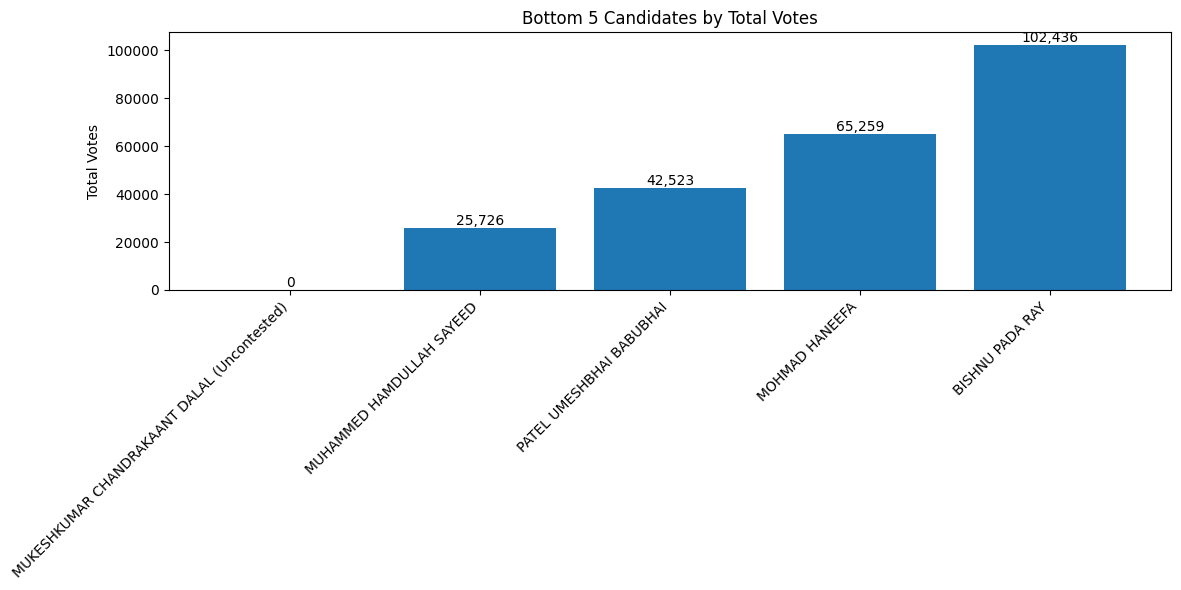

Bottom 5 candidates by total votes:
                           Winning Candidate                          Party                 Constituency  Total Votes
MUKESHKUMAR CHANDRAKAANT DALAL (Uncontested)   Bharatiya Janata Party - BJP                    Surat(24)            0
                   MUHAMMED HAMDULLAH SAYEED Indian National Congress - INC               Lakshadweep(1)        25726
                    PATEL UMESHBHAI BABUBHAI              Independent - IND              Daman & Diu (1)        42523
                              MOHMAD HANEEFA              Independent - IND                    Ladakh(1)        65259
                             BISHNU PADA RAY   Bharatiya Janata Party - BJP Andaman & Nicobar Islands(1)       102436


In [68]:
def least_5_candidates_by_votes(candidate_df):
    bottom_5 = candidate_df.nsmallest(5, 'Total Votes')

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(bottom_5['Winning Candidate'], bottom_5['Total Votes'])
    ax.set_title("Bottom 5 Candidates by Total Votes")
    ax.set_ylabel("Total Votes")
    plt.xticks(rotation=45, ha='right')
    for i, v in enumerate(bottom_5['Total Votes']):
        ax.text(i, v, f'{v:,}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

    return f"Bottom 5 candidates by total votes:\n{bottom_5[['Winning Candidate', 'Party', 'Constituency', 'Total Votes']].to_string(index=False)}"

print(least_5_candidates_by_votes(candidate_df))


In [135]:
csv_file = "candidate_data.csv"

# Write data to CSV file
candidate_df.to_csv(csv_file, index=False)

print(f"CSV file '{csv_file}' has been created successfully.")

CSV file 'candidate_data.csv' has been created successfully.


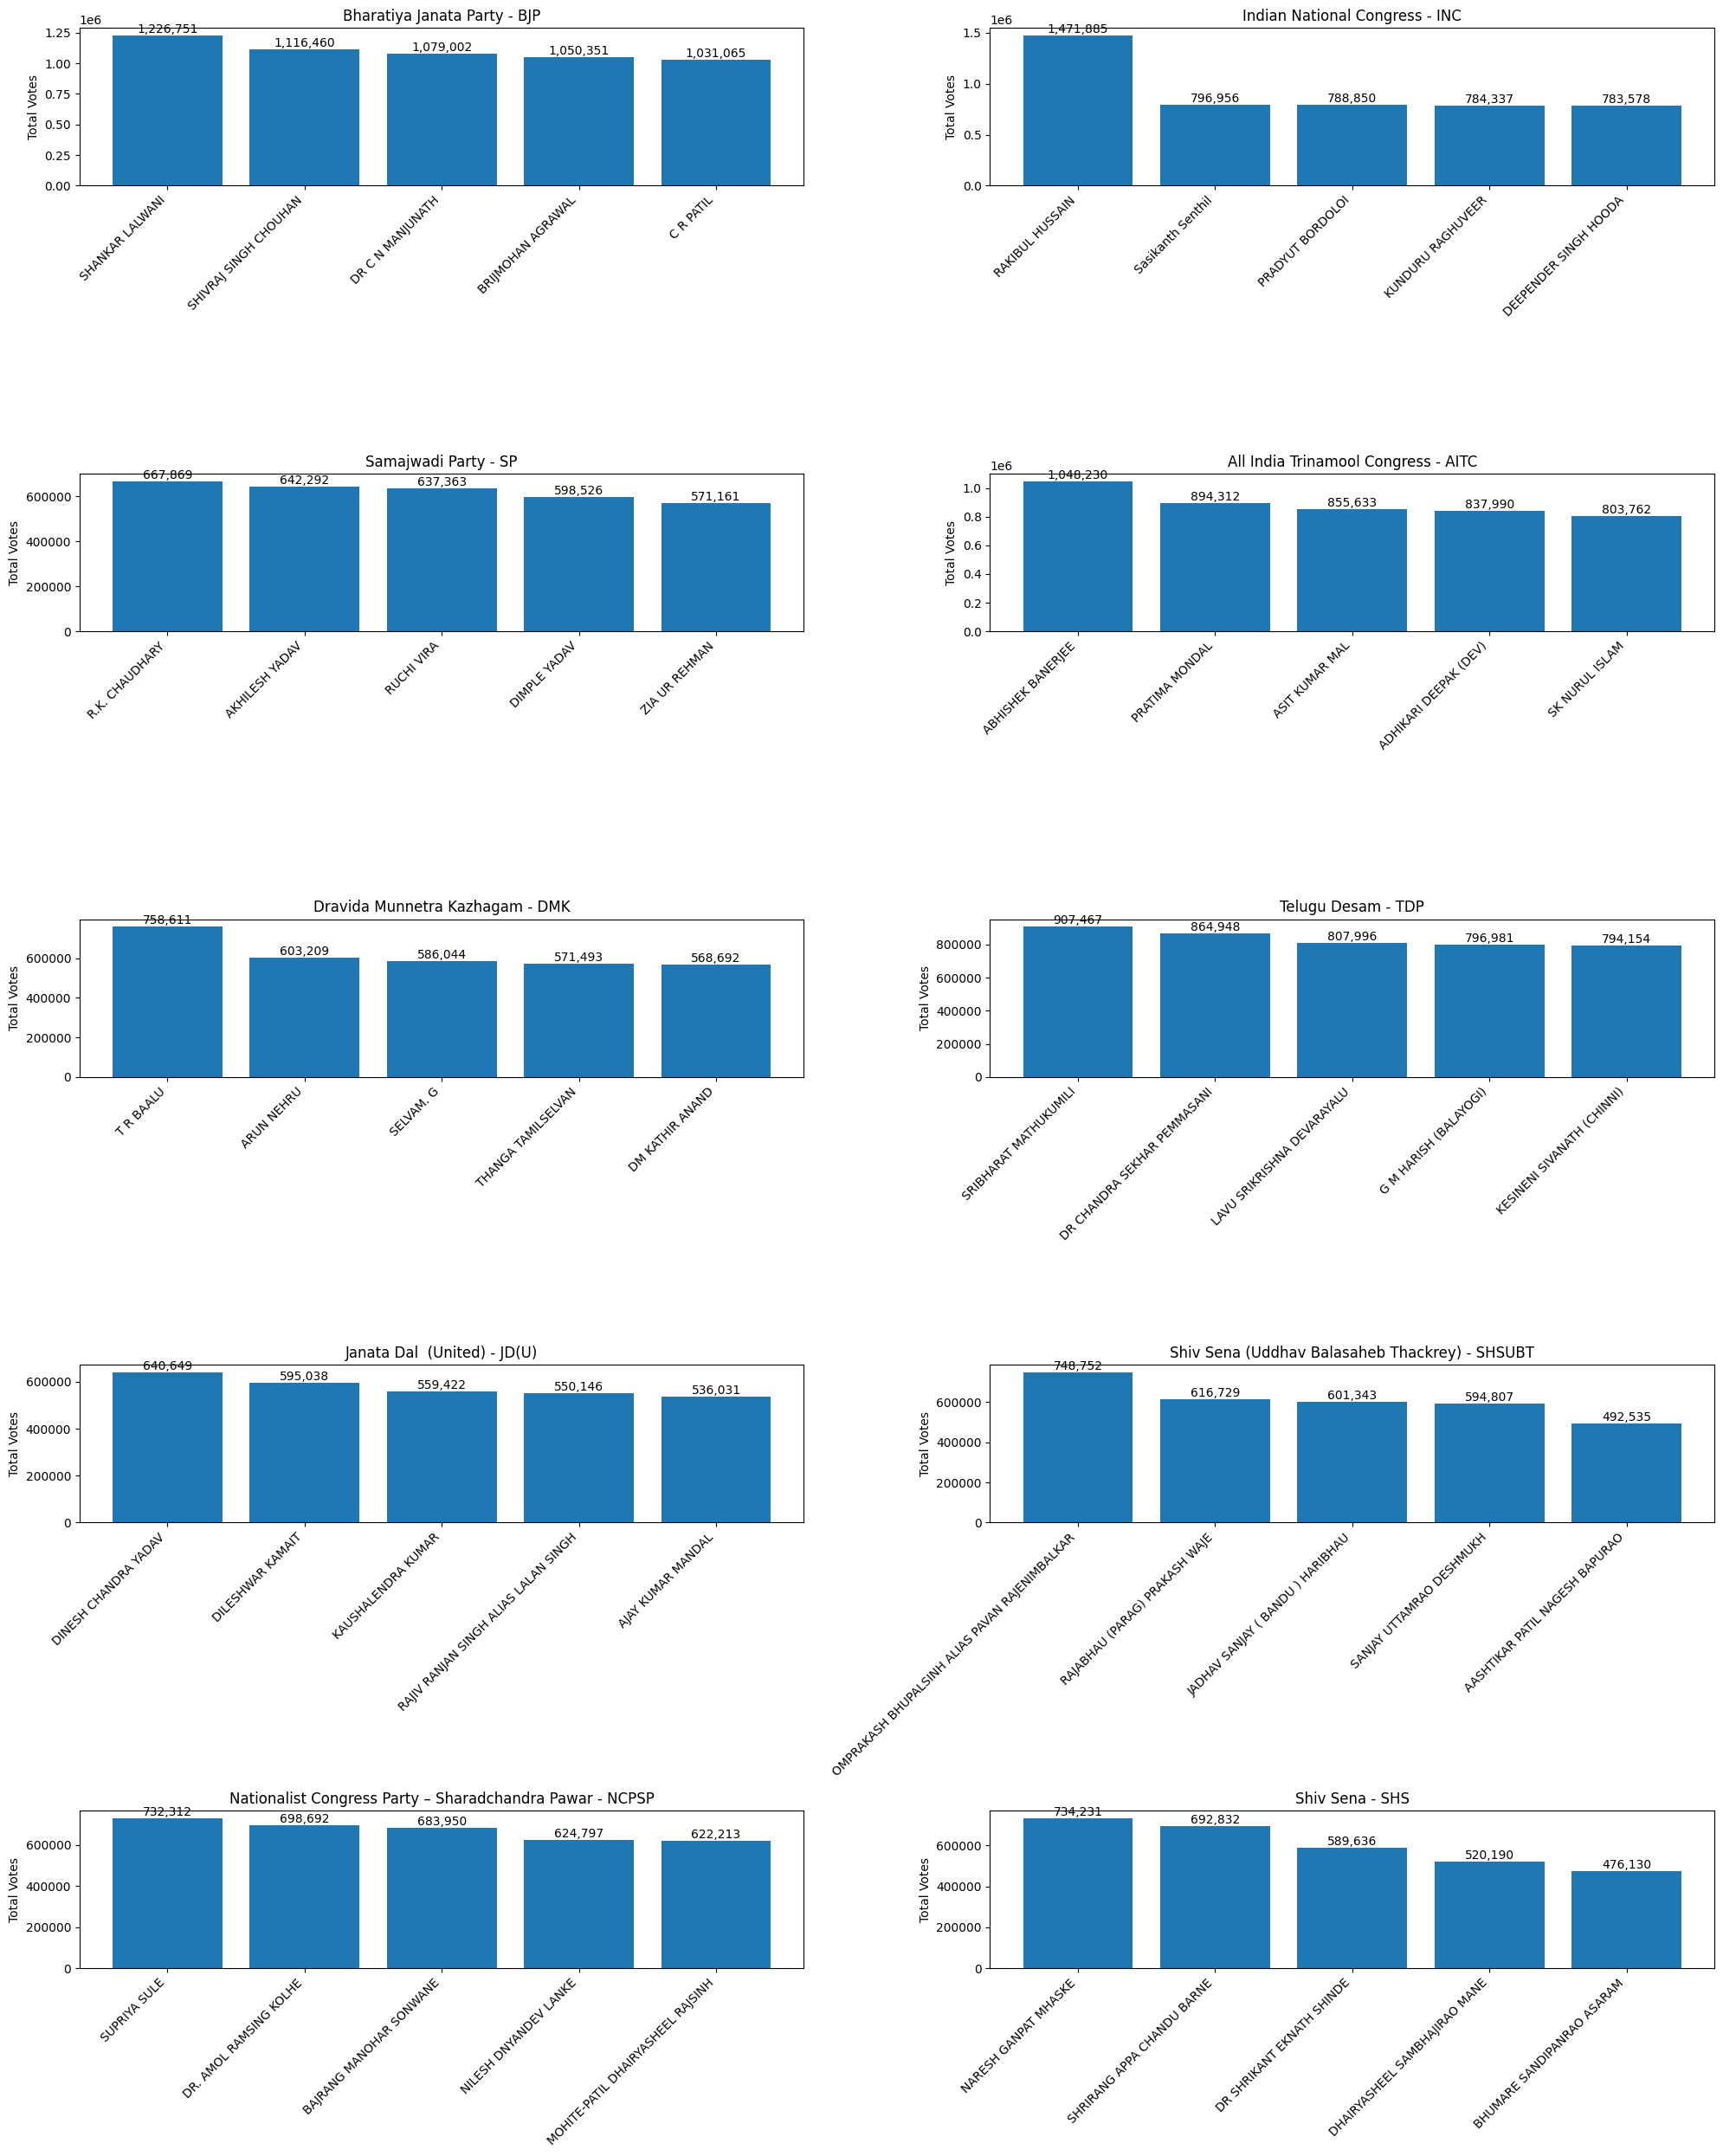

Top 5 candidates by total votes for each top 10 party:
Bharatiya Janata Party - BJP:
    Winning Candidate        Constituency  Total Votes
      SHANKAR LALWANI          INDORE(26)      1226751
SHIVRAJ SINGH CHOUHAN         VIDISHA(18)      1116460
     DR C N MANJUNATH Bangalore Rural(23)      1079002
    BRIJMOHAN AGRAWAL           RAIPUR(8)      1050351
            C R PATIL         Navsari(25)      1031065

Indian National Congress - INC:
    Winning Candidate  Constituency  Total Votes
      RAKIBUL HUSSAIN    Dhubri (2)      1471885
    Sasikanth Senthil TIRUVALLUR(1)       796956
     PRADYUT BORDOLOI     Nagaon(9)       788850
    KUNDURU RAGHUVEER  Nalgonda(13)       784337
DEEPENDER SINGH HOODA     ROHTAK(7)       783578

Samajwadi Party - SP:
Winning Candidate     Constituency  Total Votes
   R.K. CHAUDHARY Mohanlalganj(34)       667869
   AKHILESH YADAV      Kannauj(42)       642292
       RUCHI VIRA     Moradabad(6)       637363
     DIMPLE YADAV     Mainpuri(21)       59

In [69]:
def top_5_candidates_by_votes_top_10_parties(df, candidate_df):
    top_10_parties = df.nlargest(10, 'Total')['Party'].tolist()
    results = []
    fig, axs = plt.subplots(5, 2, figsize=(20, 25))
    axs = axs.ravel()

    for i, party in enumerate(top_10_parties):
        party_candidates = candidate_df[candidate_df['Party'] == party]
        top_5 = party_candidates.nlargest(5, 'Total Votes')
        results.append(f"\n{party}:\n{top_5[['Winning Candidate', 'Constituency', 'Total Votes']].to_string(index=False)}")

        axs[i].bar(top_5['Winning Candidate'], top_5['Total Votes'])
        axs[i].set_title(f"{party}")
        axs[i].set_xticklabels(top_5['Winning Candidate'], rotation=45, ha='right')
        axs[i].set_ylabel('Total Votes')
        for j, v in enumerate(top_5['Total Votes']):
            axs[i].text(j, v, f'{v:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    return "Top 5 candidates by total votes for each top 10 party:" + '\n'.join(results)

print(top_5_candidates_by_votes_top_10_parties(df, candidate_df))


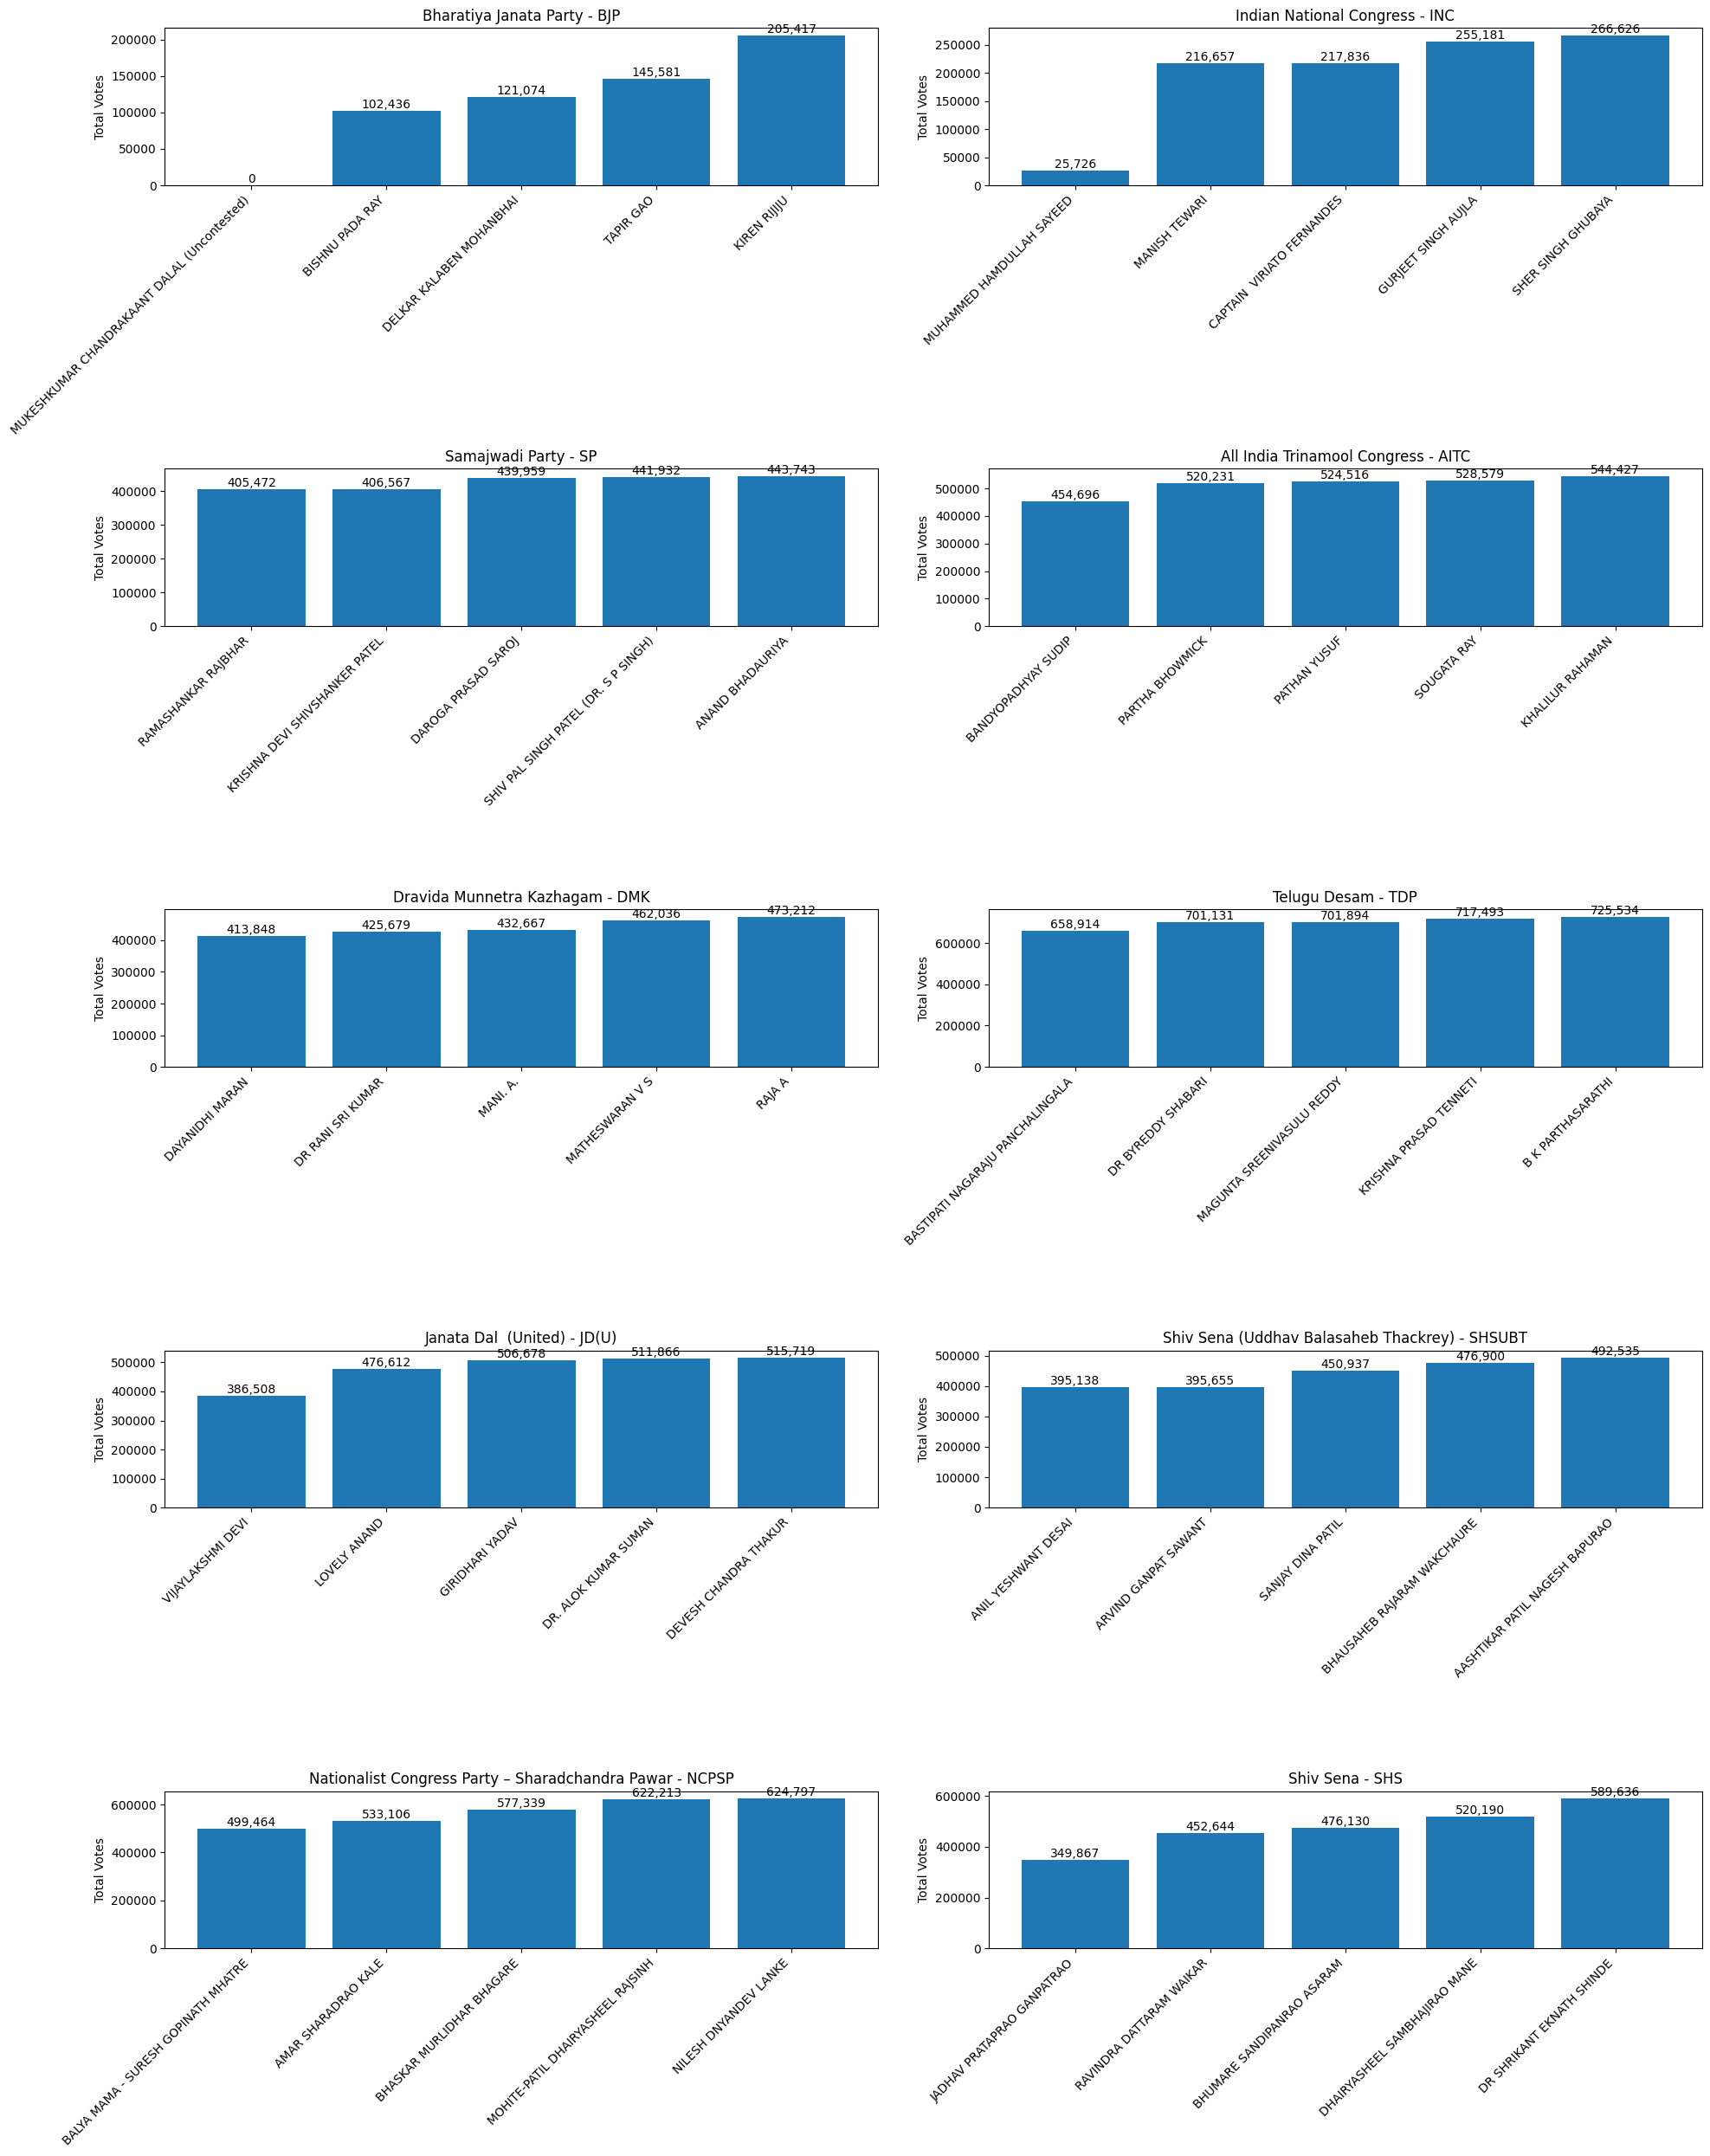

Least 5 candidates by total votes for each top 10 party:
Bharatiya Janata Party - BJP:
                           Winning Candidate                 Constituency  Total Votes
MUKESHKUMAR CHANDRAKAANT DALAL (Uncontested)                    Surat(24)            0
                             BISHNU PADA RAY Andaman & Nicobar Islands(1)       102436
                    DELKAR KALABEN MOHANBHAI      Dadar & Nagar Haveli(2)       121074
                                   TAPIR GAO            Arunachal East(2)       145581
                                KIREN RIJIJU            Arunachal West(1)       205417

Indian National Congress - INC:
         Winning Candidate   Constituency  Total Votes
 MUHAMMED HAMDULLAH SAYEED Lakshadweep(1)        25726
             MANISH TEWARI  Chandigarh(1)       216657
CAPTAIN  VIRIATO FERNANDES   South Goa(2)       217836
       GURJEET SINGH AUJLA    Amritsar(2)       255181
        SHER SINGH GHUBAYA   Firozpur(10)       266626

Samajwadi Party - SP:
     

In [70]:
def least_5_candidates_by_votes_top_10_parties(df, candidate_df):
    top_10_parties = df.nlargest(10, 'Total')['Party'].tolist()
    results = []
    fig, axs = plt.subplots(5, 2, figsize=(20, 25))
    axs = axs.ravel()

    for i, party in enumerate(top_10_parties):
        party_candidates = candidate_df[candidate_df['Party'] == party]
        least_5 = party_candidates.nsmallest(5, 'Total Votes')
        results.append(f"\n{party}:\n{least_5[['Winning Candidate', 'Constituency', 'Total Votes']].to_string(index=False)}")

        axs[i].bar(least_5['Winning Candidate'], least_5['Total Votes'])
        axs[i].set_title(f"{party}")
        axs[i].set_xticklabels(least_5['Winning Candidate'], rotation=45, ha='right')
        axs[i].set_ylabel('Total Votes')
        for j, v in enumerate(least_5['Total Votes']):
            axs[i].text(j, v, f'{v:,}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()
    return "Least 5 candidates by total votes for each top 10 party:" + '\n'.join(results)

print(least_5_candidates_by_votes_top_10_parties(df, candidate_df))


In [136]:

def top_5_candidates_by_votes_top_10_parties(df, candidate_df):
    top_10_parties = df.nlargest(10, 'Total')['Party'].tolist()
    results = []

    for party in top_10_parties:
        party_candidates = candidate_df[candidate_df['Party'] == party]
        top_5 = party_candidates.nlargest(5, 'Total Votes')
        results.append(f"\n{party}:\n{top_5[['Winning Candidate', 'Constituency', 'Total Votes']].to_string(index=False)}")

        # Save party's top 5 candidates to CSV
        csv_file = f"{party}_top_5_candidates.csv"
        top_5.to_csv(csv_file, index=False)

    return "Top 5 candidates by total votes for each top 10 party:" + '\n'.join(results)

def least_5_candidates_by_votes_top_10_parties(df, candidate_df):
    top_10_parties = df.nlargest(10, 'Total')['Party'].tolist()
    results = []
    for party in top_10_parties:
        party_candidates = candidate_df[candidate_df['Party'] == party]
        top_5 = party_candidates.nlargest(5, 'Total Votes')
        results.append(f"\n{party}:\n{top_5[['Winning Candidate', 'Constituency', 'Total Votes']].to_string(index=False)}")

        # Save party's top 5 candidates to CSV
        csv_file = f"{party}_top_5_candidates.csv"
        top_5.to_csv(csv_file, index=False)

    return "Least 5 candidates by total votes for each top 10 party:" + '\n'.join(results)



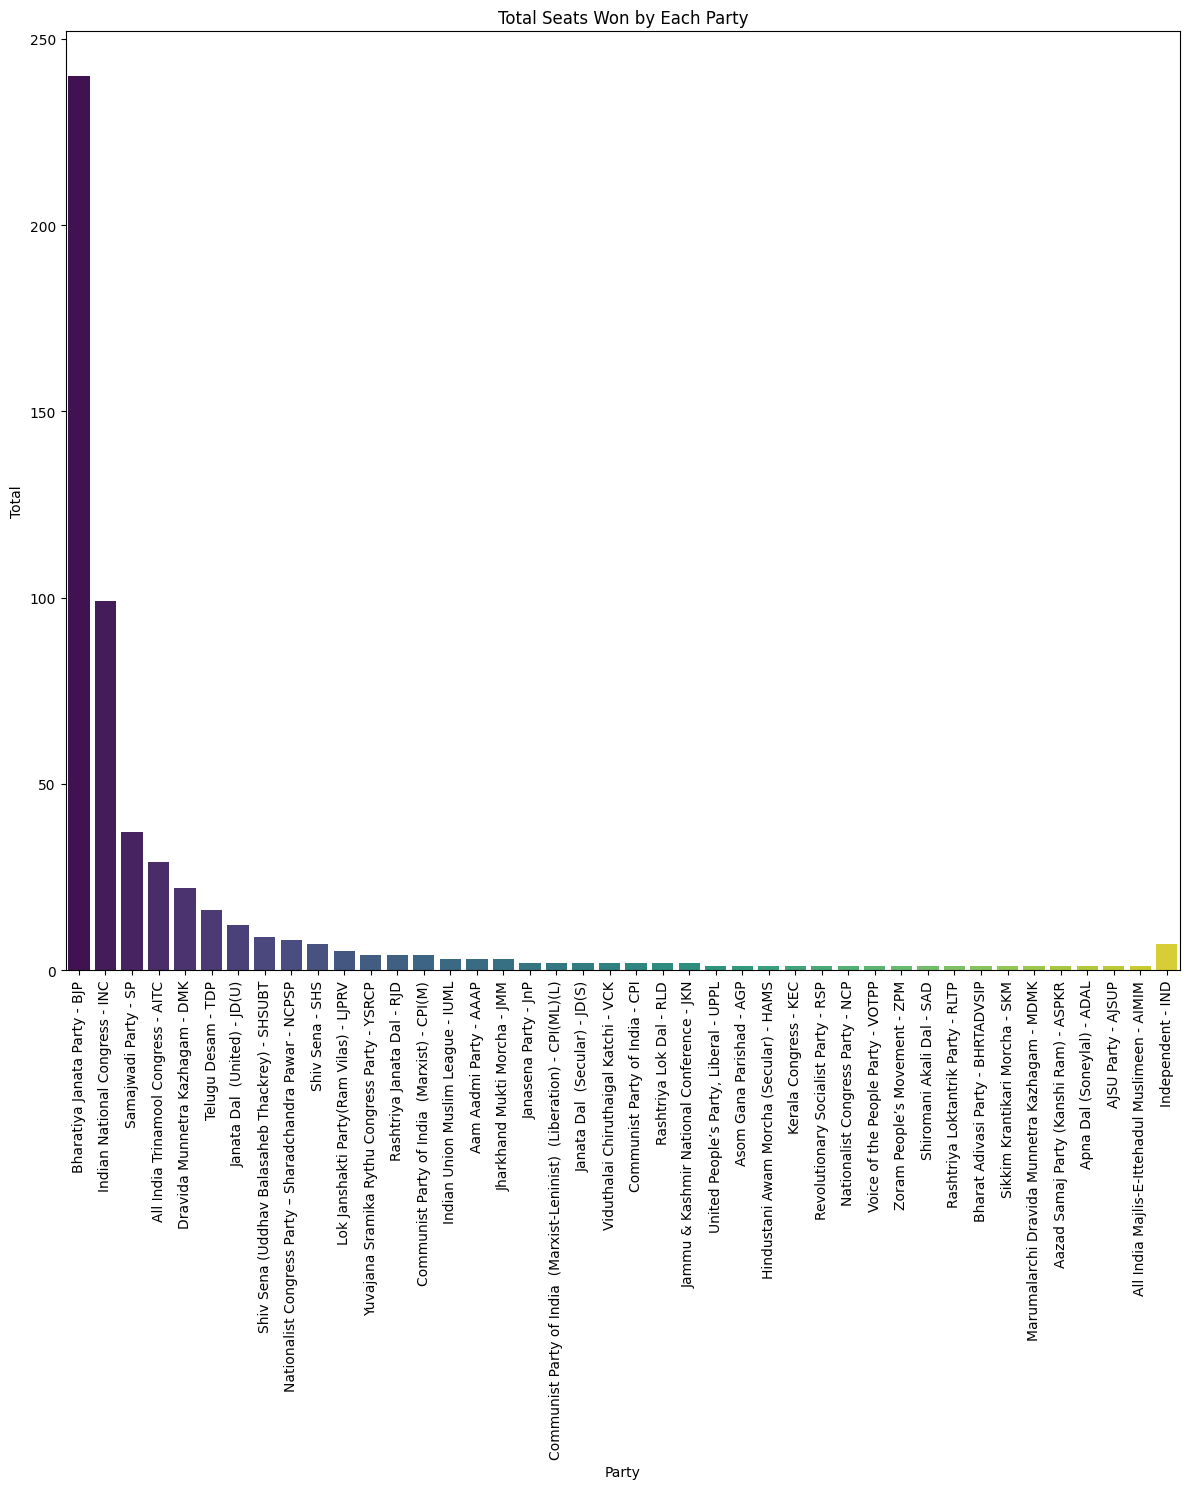

In [71]:
plt.figure(figsize=(12, 15))
sns.barplot(x='Party', y='Total', data=df, palette='viridis')
plt.title('Total Seats Won by Each Party')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


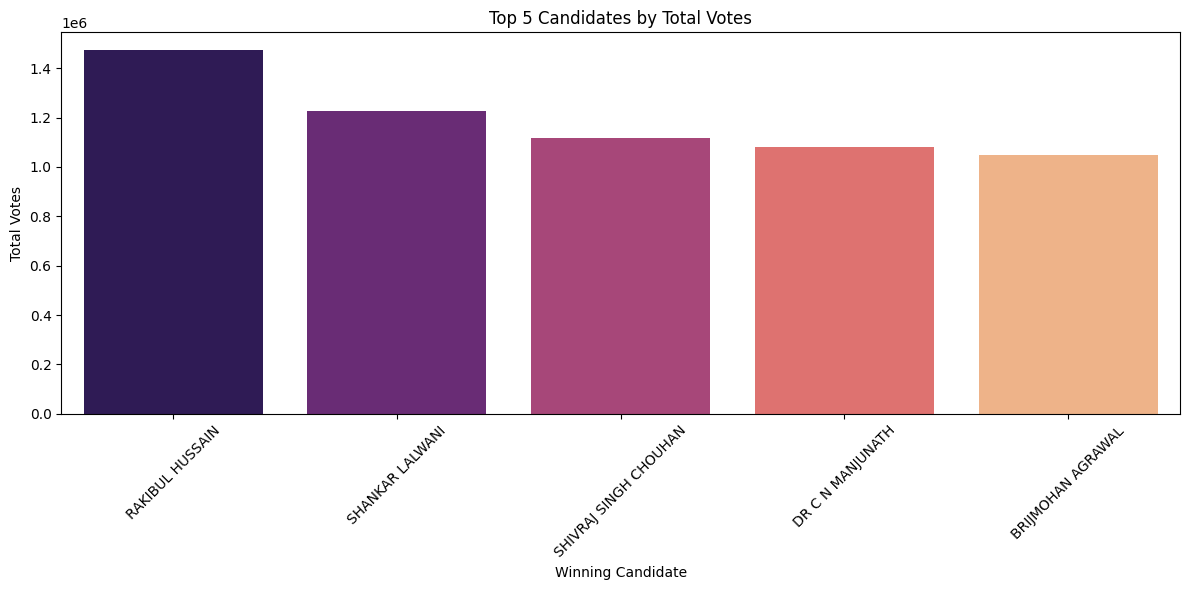

In [72]:
top_5 = candidate_df.nlargest(5, 'Total Votes')

plt.figure(figsize=(12, 6))
sns.barplot(x='Winning Candidate', y='Total Votes', data=top_5, palette='magma')
plt.title('Top 5 Candidates by Total Votes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


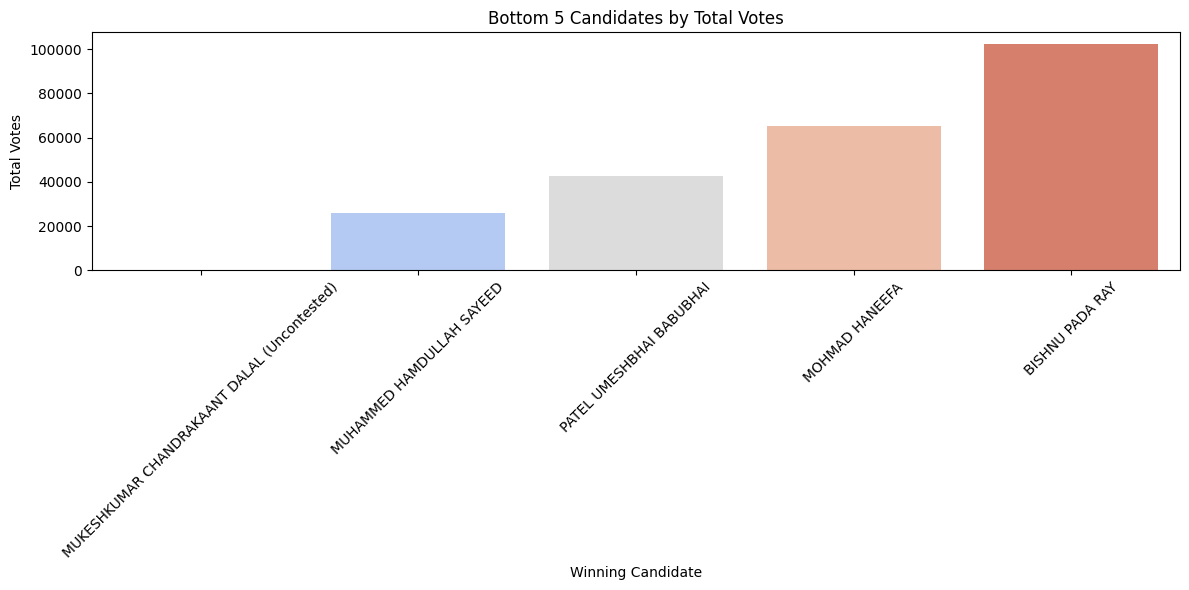

In [73]:
bottom_5 = candidate_df.nsmallest(5, 'Total Votes')

plt.figure(figsize=(12, 6))
sns.barplot(x='Winning Candidate', y='Total Votes', data=bottom_5, palette='coolwarm')
plt.title('Bottom 5 Candidates by Total Votes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


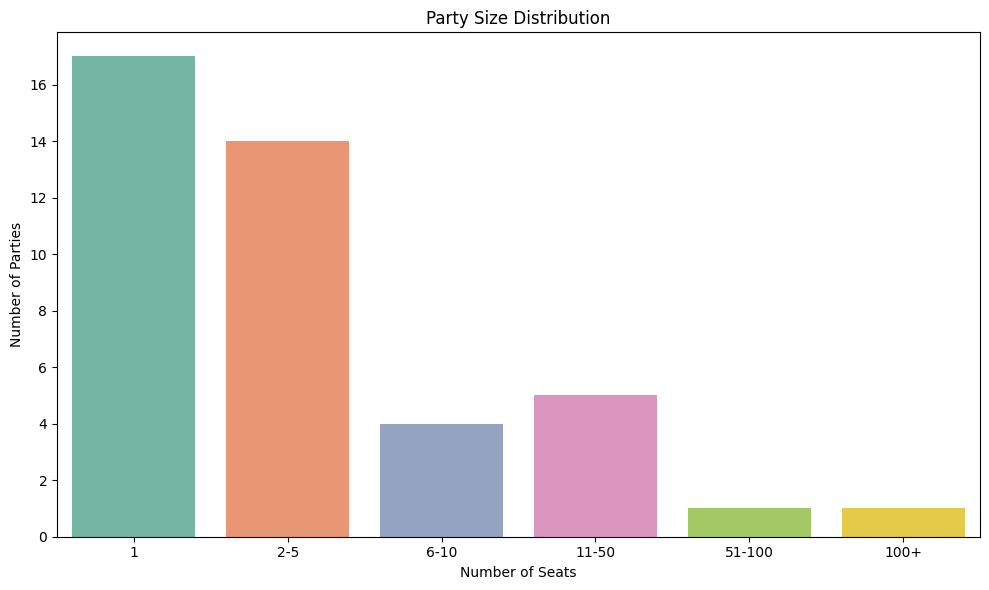

In [74]:
size_bins = [0, 2, 6, 11, 51, 101, float('inf')]
labels = ['1', '2-5', '6-10', '11-50', '51-100', '100+']
df['Size Category'] = pd.cut(df['Total'], bins=size_bins, labels=labels, right=False)

plt.figure(figsize=(10, 6))
sns.countplot(x='Size Category', data=df, palette='Set2')
plt.title('Party Size Distribution')
plt.xlabel('Number of Seats')
plt.ylabel('Number of Parties')
plt.tight_layout()
plt.show()


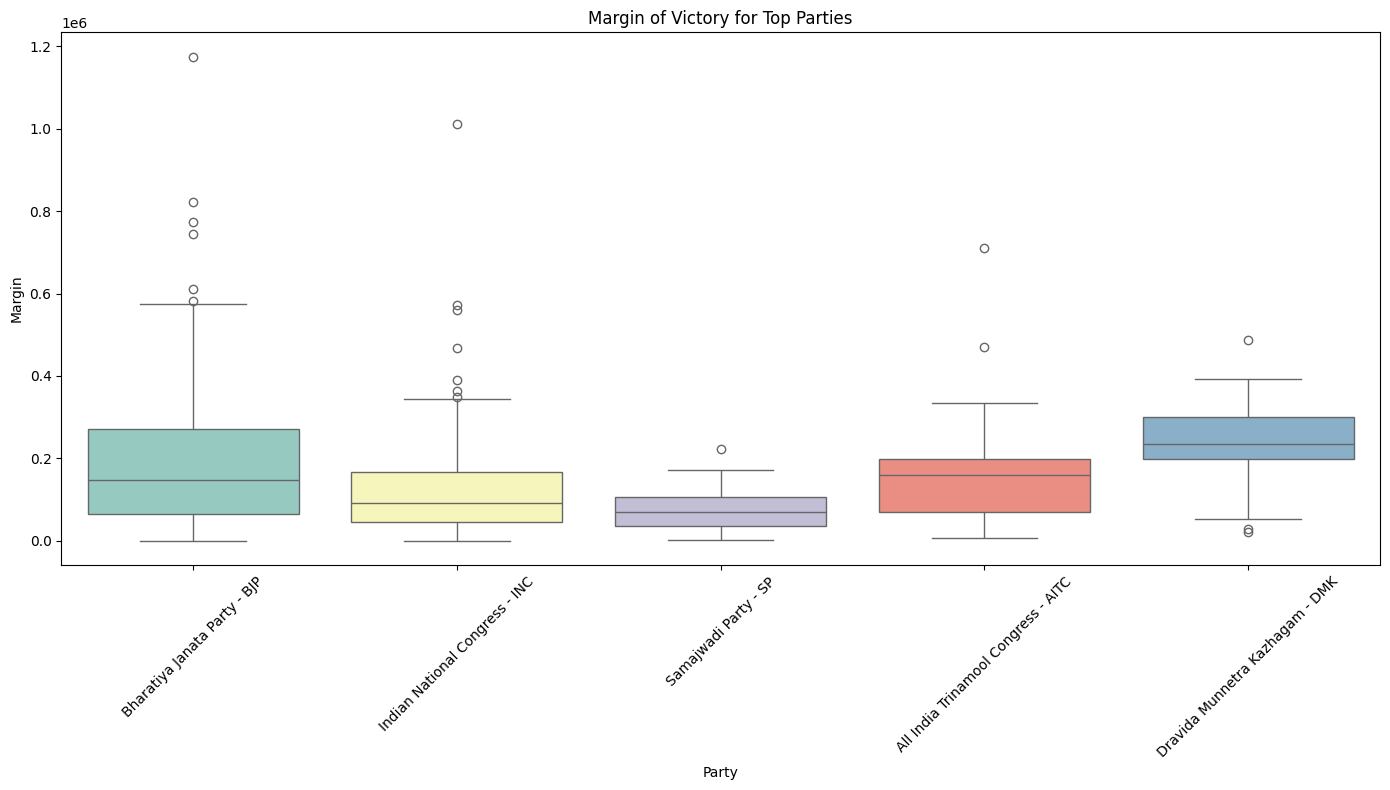

In [75]:
top_parties = df.nlargest(5, 'Total')['Party'].tolist()
top_party_candidates = candidate_df[candidate_df['Party'].isin(top_parties)]

plt.figure(figsize=(14, 8))
sns.boxplot(x='Party', y='Margin', data=top_party_candidates, palette='Set3')
plt.title('Margin of Victory for Top Parties')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:

from selenium.webdriver.common.keys import Keys
# URL of the election results page
url = 'https://results.eci.gov.in/PcResultGenJune2024/index.htm'

response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
soup

options = soup.find_all('option')
states = [option.text for option in options if option['value']]



driver = webdriver.Chrome()
driver.get(url)

csv_file = "state_results.csv"

# Flag to check if headers have been written
headers_written = False

for i in range(2, len(states)+1):
    try:
        entr = driver.find_element('xpath','/html/body/main/div/section/div/div[2]/div[1]/div/div[1]/div')
        entr.click()
        time.sleep(3)
        new = driver.find_element('xpath',f'//*[@id="ctl00_ContentPlaceHolder1_Result1_ddlState"]/option[{i}]')
        new.click()
        time.sleep(3)
        
        page_source = driver.page_source
        page_soup = BeautifulSoup(page_source, 'lxml')
        table = page_soup.find('table', class_='table')
        
        headers = [header.text.strip() for header in table.find_all('th')[0:4]]
        # Extract table rows
        rows = []
        for row in table.find_all('tr', class_='tr'):
            cols = row.find_all('td')[0:4]
            cols = [ele.text.strip() for ele in cols]
            rows.append(cols)

        txt = []
        text = page_soup.find_all('strong')[0:1]
        txt.append(text)
        
        # Write to CSV file in append mode
        with open(csv_file, 'a', newline='') as f:
            writer = csv.writer(f)
            if not headers_written:
                writer.writerow(headers)
                headers_written = True
            writer.writerows(rows)
            writer.writerows(txt)

        print(f"Data has been written to {csv_file}")
        time.sleep(3)
        
        
        
        bttn = driver.find_element('xpath','/html/body/header/div/div[3]/ul/li[1]/a')
        bttn.click()
        time.sleep(3)
    except Exception as e:
        print(f"An error occurred at index {i}: {e}")
        
    
    
driver.quit()





"""
//*[@id="ctl00_ContentPlaceHolder1_Result1_ddlState"]/option[2]
//*[@id="ctl00_ContentPlaceHolder1_Result1_ddlState"]/option[3]
//*[@id="ctl00_ContentPlaceHolder1_Result1_ddlState"]/option[4]
"""